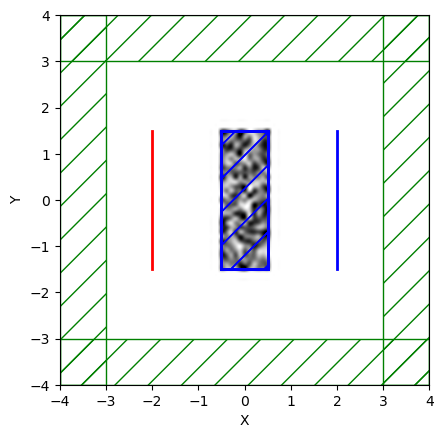

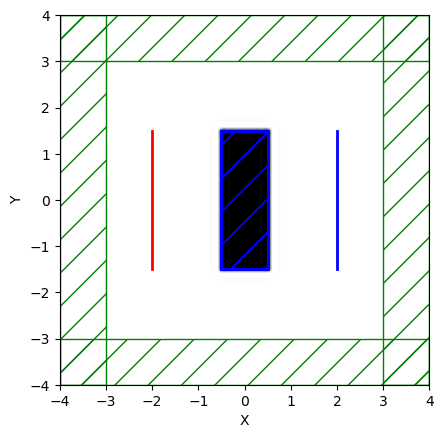

In [ ]:
## dielectric lens ## 
import meep as mp
import meep.adjoint as mpa
import numpy as np
from autograd import numpy as npa
import nlopt
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

mp.verbosity(0)

Si = mp.Medium(index=3.4)

cell_size = mp.Vector3(8, 8, 0)
pml_layers = [mp.PML(1.0)]
resolution = 10

# source
source_center = [-2, 0, 0]
source_size = mp.Vector3(0, 3, 0)
fcen = 1 / 1.55
width = 0.2
fwidth = width * fcen
kpoint = mp.Vector3(1, 0, 0)
src = mp.GaussianSource(frequency=fcen, fwidth=fwidth)
source = [
    mp.EigenModeSource(
        src,
        eig_band=1,
        direction=mp.NO_DIRECTION,
        eig_kpoint=kpoint,
        size=source_size,
        center=source_center,
    )
]

# design region
Lx = 1
Ly = 3
design_region_resolution = int(resolution)
Nx = design_region_resolution * Lx + 1
Ny = design_region_resolution * Ly + 1

design_variables = mp.MaterialGrid(mp.Vector3(Nx,Ny,0),
                                   mp.air,
                                   Si,
                                   grid_type="U_MEAN")
design_region = mpa.DesignRegion(design_variables,
                                 volume=mp.Volume(center=mp.Vector3(), size=mp.Vector3(Lx,Ly,0)))                             

geometry = [mp.Block(center=design_region.center,
                     size=design_region.size,
                     material=design_variables)]

sim = mp.Simulation(
    cell_size=cell_size,
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=source,
    eps_averaging=False,
    resolution=resolution
)

# adjoint optimization setup
TE_top =mpa.EigenmodeCoefficient(
    sim,
    mp.Volume(center=mp.Vector3(2, 0, 0), size=mp.Vector3(0, 3, 0)),
    mode=1
)
ob_list = [TE_top]

def J(alpha):
    return npa.abs(alpha) ** 2

opt = mpa.OptimizationProblem(
    simulation=sim,
    objective_functions=J,
    objective_arguments=ob_list,
    design_regions=[design_region],
    fcen=fcen,
    df=0,
    nf=1,
)

x0 = np.random.rand(Nx * Ny)
opt.update_design([x0])

opt.plot2D(True, frequency=1/1.55)
plt.show()

x0 = 0.5 * np.ones((Nx * Ny, ))
opt.update_design([x0])

opt.plot2D(True)
plt.show()


In [21]:
evaluation_history = []
sensitivity = [0]

def f(x, grad):
    f0, dJ_du = opt([x])
    f0 = f0[0]
    if grad.size > 0:
        grad[:] = np.squeeze(dJ_du)
    evaluation_history.append(np.real(f0))
    sensitivity[0] = dJ_du
    return np.real(f0)

algorithm = nlopt.LD_MMA
n = Nx * Ny
maxeval = 10

solver = nlopt.opt(algorithm, n)
solver.set_lower_bounds(0)
solver.set_upper_bounds(1)
solver.set_max_objective(f)
solver.set_maxeval(maxeval)

x = solver.optimize(x0)

Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...


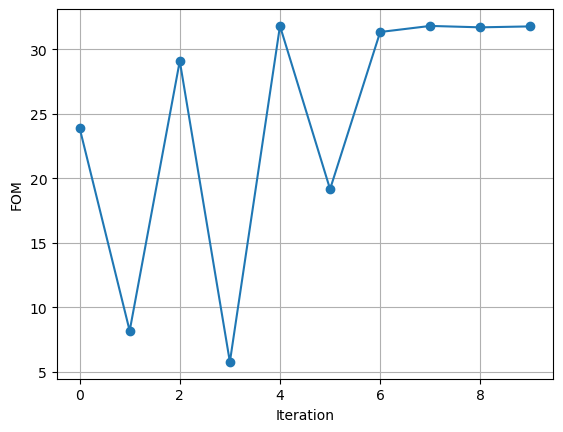

In [5]:
plt.figure()
plt.plot(evaluation_history, "o-")
plt.grid(True)
plt.xlabel("Iteration")
plt.ylabel("FOM")
plt.show()

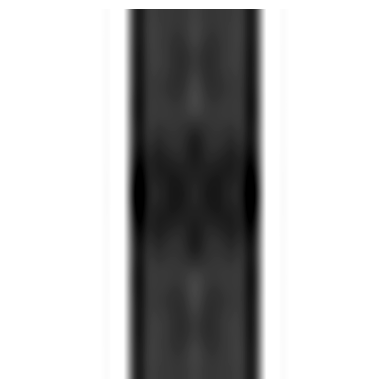

In [24]:
opt.update_design([x])

plt.figure()
sim.plot2D(
    output_plane=mp.Volume(center=mp.Vector3(), size=mp.Vector3(3,3,0))
)
plt.axis("off")
plt.show()

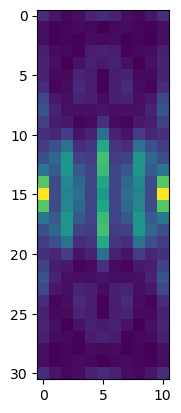

In [25]:
plt.imshow(np.rot90(np.squeeze(np.abs(sensitivity[0].reshape(Nx, Ny)))))